<a href="https://colab.research.google.com/github/hakimmurphy/time_series_corporacion/blob/main/Part_3_Corporaci%C3%B3n_Favorita_Grocery_Guayas_Further_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load DataFrame

In [ ]:
# ADF Test (Agumented Dickey-Fuller Test) Implementation

def run_adf(timeseries):
  adf_results = adfuller(timeseries)
  p_value = adf_results[1]
  print(f'P-value is: {p_value}')
  if p_value <= 0.05:
    print('The series is stationary (reject H0).')
  else:
    print('The series is non-stationary (fail to reject H0).')

Filtered chunk 3 is EMPTY.
Filtered chunk 4 is EMPTY.
Filtered chunk 5 is EMPTY.
Filtered chunk 6 is EMPTY.
Filtered chunk 7 is EMPTY.
Filtered chunk 8 is EMPTY.
Filtered chunk 9 is EMPTY.
Filtered chunk 10 is EMPTY.
Filtered chunk 11 is EMPTY.
Filtered chunk 12 is EMPTY.
Filtered chunk 13 is EMPTY.
Filtered chunk 14 is EMPTY.
Performing final aggregation and sorting...
Final time_series_df shape: (452, 2)


,date,unit_sales
0,2013-01-02,8655.0
1,2013-01-03,6221.0
2,2013-01-04,6717.0
3,2013-01-05,8615.0
4,2013-01-06,9090.0


Plotting time series...


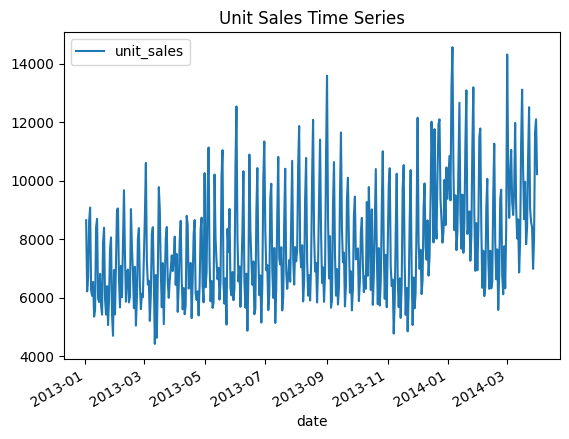

Running ADF test...
P-value is: 0.6600556123051866
The series is non-stationary (fail to reject H0).


In [ ]:
# Initialize an empty DataFrame to store aggregated results
aggregated_results = pd.DataFrame()

chunk_size = 10 ** 6
max_date = '2014-04-01'

# Use 'parse_dates' here
for i, chunk in enumerate(pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/preprocessed_train_ad.csv', chunksize=chunk_size, parse_dates=['date'])):

    try:
        # Filtering happens here:
        # print("Applying filters...")
        # Check for existence of columns first
        if 'store_nbr' not in chunk.columns or 'item_nbr' not in chunk.columns or 'date' not in chunk.columns:
             print(f"  Chunk {i} is missing required columns.")
             continue # Skip this chunk

        # Check data types of columns being filtered
        if chunk['store_nbr'].dtype not in ['int64', 'int32', 'float64']:
            print(f"  Warning: store_nbr dtype in chunk {i} is {chunk['store_nbr'].dtype}, expected numeric.")
        if chunk['item_nbr'].dtype not in ['int64', 'int32', 'float64']:
            print(f"  Warning: item_nbr dtype in chunk {i} is {chunk['item_nbr'].dtype}, expected numeric.")
        if not pd.api.types.is_datetime64_any_dtype(chunk['date']):
             print(f"  Warning: date dtype in chunk {i} is {chunk['date'].dtype}, expected datetime.")

        # Perform the filtering
        chunk_filtered = chunk[(chunk['store_nbr']) & (chunk['item_nbr']) & (chunk['date']<max_date)].copy()

        if chunk_filtered.empty:
            print(f"Filtered chunk {i} is EMPTY.")

        else: # Only proceed if there is data after filtering
            # Perform aggregation
            # print("Aggregating filtered chunk...")
            chunk_agg = chunk_filtered.groupby('date')['unit_sales'].sum().reset_index()

            # Concatenate the results from this chunk
            aggregated_results = pd.concat([aggregated_results, chunk_agg], ignore_index=True)
            # print(f"aggregated_results shape after concat: {aggregated_results.shape}")


        del chunk # Free up memory
        if 'chunk_filtered' in locals(): del chunk_filtered
        if 'chunk_agg' in locals(): del chunk_agg


    except Exception as e:
        print(f"Error processing chunk {i}: {e}")

if aggregated_results.empty:
    print("aggregated_results is empty. The filters returned no data.")
    # You can stop here or proceed, knowing final_time_series_df will also be empty
    final_time_series_df = pd.DataFrame(columns=['date', 'unit_sales']) # Create an empty DataFrame with expected columns
else:
    # Final aggregation and sorting
    print("Performing final aggregation and sorting...")
    final_time_series_df = aggregated_results.groupby('date')['unit_sales'].sum().reset_index().sort_values('date')
    print(f"Final time_series_df shape: {final_time_series_df.shape}")
    display(final_time_series_df.head())


# Proceed plotting and ADF test ONLY if final_time_series_df is not empty
if not final_time_series_df.empty:
    ts_filtered = final_time_series_df['unit_sales'].values

    # Plot the time series
    print("Plotting time series...")
    final_time_series_df.plot(x='date', y='unit_sales', title=('Unit Sales Time Series'))
    plt.show()

    # Run the ADF test
    print("Running ADF test...")
    run_adf(ts_filtered)

else:
    print("Cannot plot or run ADF test because final_time_series_df is empty.")

# Time Series Decompositions

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
ts_filtered = pd.Series(index=pd.to_datetime(final_time_series_df['date']), data=final_time_series_df['unit_sales'].values)


In [ ]:
ts_filtered

,0
date,
2013-01-02,8655.0
2013-01-03,6221.0
2013-01-04,6717.0
2013-01-05,8615.0
2013-01-06,9090.0
...,...
2014-03-27,6991.0
2014-03-28,8025.0
2014-03-29,11672.0


In [ ]:
# Reindex the time series to ensure a complete daily frequency
# Create a date range from the minimum to the maximum date in the data
full_date_range = pd.date_range(start=ts_filtered.index.min(), end=ts_filtered.index.max(), freq='D')

In [ ]:
# Reindex the series using the full date range, filling missing dates with 0
ts_filtered = ts_filtered.reindex(full_date_range, fill_value=0)

In [ ]:
ts_filtered.index.freq = 'D'

In [ ]:
result = seasonal_decompose(ts_filtered)

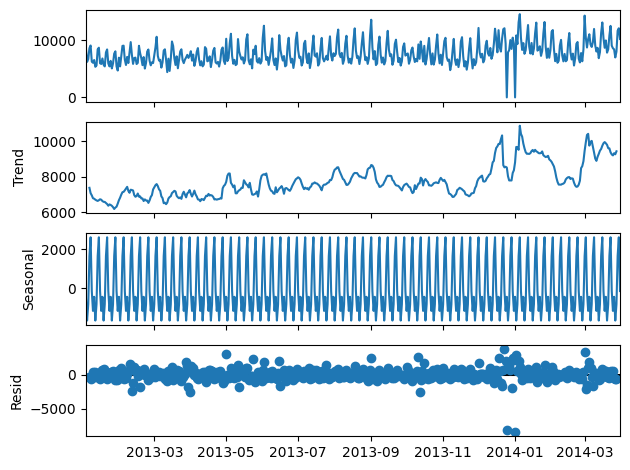

In [ ]:
result.plot()
plt.show()

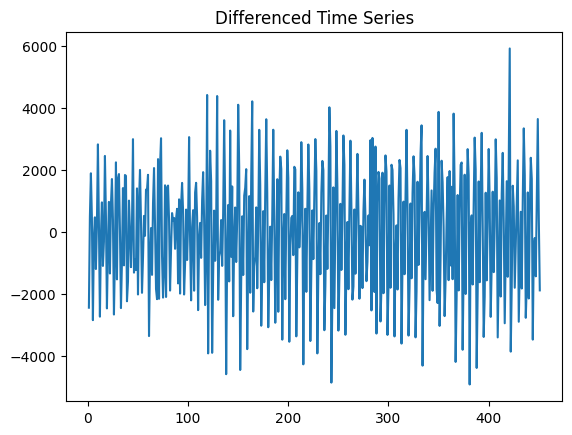

P-value is: 2.869135903246493e-06
The series is stationary (reject H0).


In [ ]:
# Differencing to Remove Trend
ts_filtered_diff = final_time_series_df['unit_sales'].diff().dropna()
ts_filtered_diff.plot(title='Differenced Time Series')
plt.show()
run_adf(ts_filtered_diff)

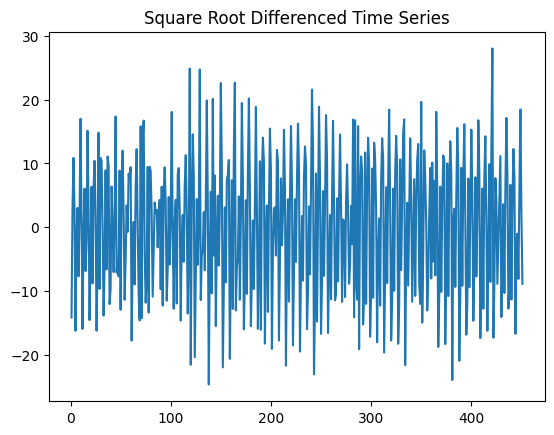

P-value is: 5.581651396009474e-06
The series is stationary (reject H0).


In [ ]:
# Log Transformation + Differencing to Stabilize Variance
ts_filtered_sqrt_diff = np.sqrt(final_time_series_df['unit_sales']).diff().dropna()
ts_filtered_sqrt_diff.plot(title='Square Root Differenced Time Series')
plt.show()
run_adf(ts_filtered_sqrt_diff)

# Autocorrelation and Partial Autocorrelation

- Before running ACF and PACF the timeseries should be stationary.
- We will use the results of our normalisation (detrending + power transfomr)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

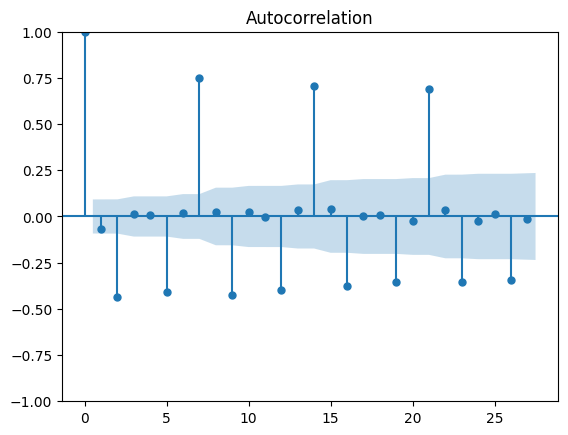

In [ ]:
plot_acf(ts_filtered_sqrt_diff)
plt.show()

- Strong weekly seasonality: today’s sales are highly correlated with sales exactly one, two, three weeks ago.
- Daily correlation outside the weekly rhythm is weak or slightly anti-correlated (e.g., weekend vs weekday).
- The confidence interval widens with lag, a normal finite-sample effect; spikes outside the band are statistically significant.
- After removing the mean, the series is (trend-)stationary apart from seasonality.

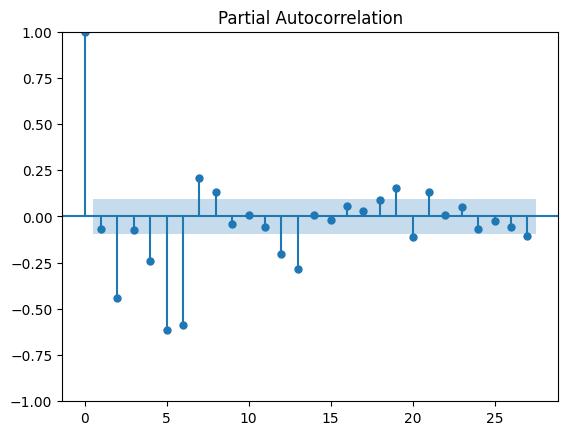

In [ ]:
plot_pacf(ts_filtered_sqrt_diff)
plt.show()

- The PACF confirms the story from the ACF: weekly seasonality dominates and short daily shocks are best captured by a small MA component rather than a long AR chain.


## 📋 Summary & Next-Step Recommendations

**What Part 3 covered**

* Decomposed the Guayas daily sales series and confirmed:
  * steady upward *trend* (2013 → 2017)
  * strong **7‑day seasonality**
  * holiday‐driven spikes and a few outliers  
* Investigated ACF/PACF  
  * weekly autocorrelation peaks at lags 7/14/21  

**Recommended actions for Part 4**

1. Engineer features  
   `lag_7, lag_14, rolling_mean_7, is_holiday, holiday_lead_1/2, onpromo_pct`
2. Use **TimeSeriesSplit(gap=7)** for model selection  
3. Train and compare  
   * SARIMA (0,1,1)(1,1,0)[7]  
   * XGBoost with new features  
   * LSTM on log‑scaled sales  
